# Does 'classical tidal theory' work for MW GCs?

The tidal limiting radius of star clusters can be inferred from observations of their radial surface density profile, of from star counts. The idea is that stars beyond a certain radius have been tidally stripped from the star cluster

In [1]:
if "logger" in globals() and  len(logger.handlers) >= 1:
    # To suppress debug output from the logger defined in .ipython/profile_default/ipython_config.py
    logger.handlers.pop()

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
import numpy
import logging
import numpy as np
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import colorcet
import matplotlib
from matplotlib import pyplot
from matplotlib import pyplot as plt
pyplot.style.use("tlrh")

# This repo: src folder /w Python scripts
sys.path.append("../src")
# Other repos linked into the notebook container ;-)
sys.path.append("/supaharris")
from data.parse_hilker_2019 import parse_individual_rvs_of_stars_in_field_of_clusters
sys.path.append("/supaharris-client")
from supaharrisclient.units import arcmin2parsec
from supaharrisclient.utils import suppress_stdout
from supaharrisclient.client import SupaHarrisClient
sys.path.append("/auriga/src")
from mw_m31_gc_observations import read_MWandM31_data
MW_h96e10, MW_v13, M31_c11, M31_cr16 = read_MWandM31_data()

logging.basicConfig(stream=sys.stdout, format="%(message)s")
logger = logging.getLogger(); logger.level = logging.INFO
for h in logger.handlers: h.setLevel(logger.level)

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_html { display: block; margin-left: auto; margin-right: auto; }</style>"))

In [4]:
# It seems that the logger propagates ..
# shc = SupaHarrisClient(base_url="https://nginx/api/v1/", loglevel=logging.CRITICAL, verify=False)

In [5]:
# Because explicit is better than implicit
from galpy.potential.PowerSphericalPotentialwCutoff import PowerSphericalPotentialwCutoff
from galpy.potential.MiyamotoNagaiPotential import MiyamotoNagaiPotential
from galpy.potential.TwoPowerSphericalPotential import NFWPotential
import galpy.util.bovy_conversion as conversion

# See Table 1 in galpy paper: Bovy (2014)
MWPotential2014= [
    # alpha: inner power; rc: cut-off radius
    PowerSphericalPotentialwCutoff(normalize=0.05, alpha=1.8, rc=1.9/8.),  # bulge
    # a: scale length, b: scale height. Do these numbers mean disk is 3kpc long, 280 parsec thick?\
    # sensible size could be 30kpc, thickness 1kpc?). But scale length/heigth goes into exponent, != max. size / extent of disk
    MiyamotoNagaiPotential(a=3./8., b=0.28/8., normalize=0.6),  # disk 
    NFWPotential(a=2., normalize=0.35)  # dark matter
]

# The normalize=1. option normalizes the potential such that the radial force
# is a fraction normalize=1. of the radial force necessary to make the
# circular velocity 1 at R=1

# To work on the different components of the potential
bulge = MWPotential2014[0]
disk = MWPotential2014[1]
dm = MWPotential2014[2]

# To compare
disk_webb_2013 = MiyamotoNagaiPotential(a=4.5/8., b=0.5/8., normalize=0.6)

# Because units
from galpy.util import bovy_conversion
to_msun = bovy_conversion.mass_in_msol(dm._vo, dm._ro)
to_msunpc3 = bovy_conversion.dens_in_msolpc3(dm._vo, dm._ro)

# What does the disk in MWPotential2014 (Bovy 2015) look like?

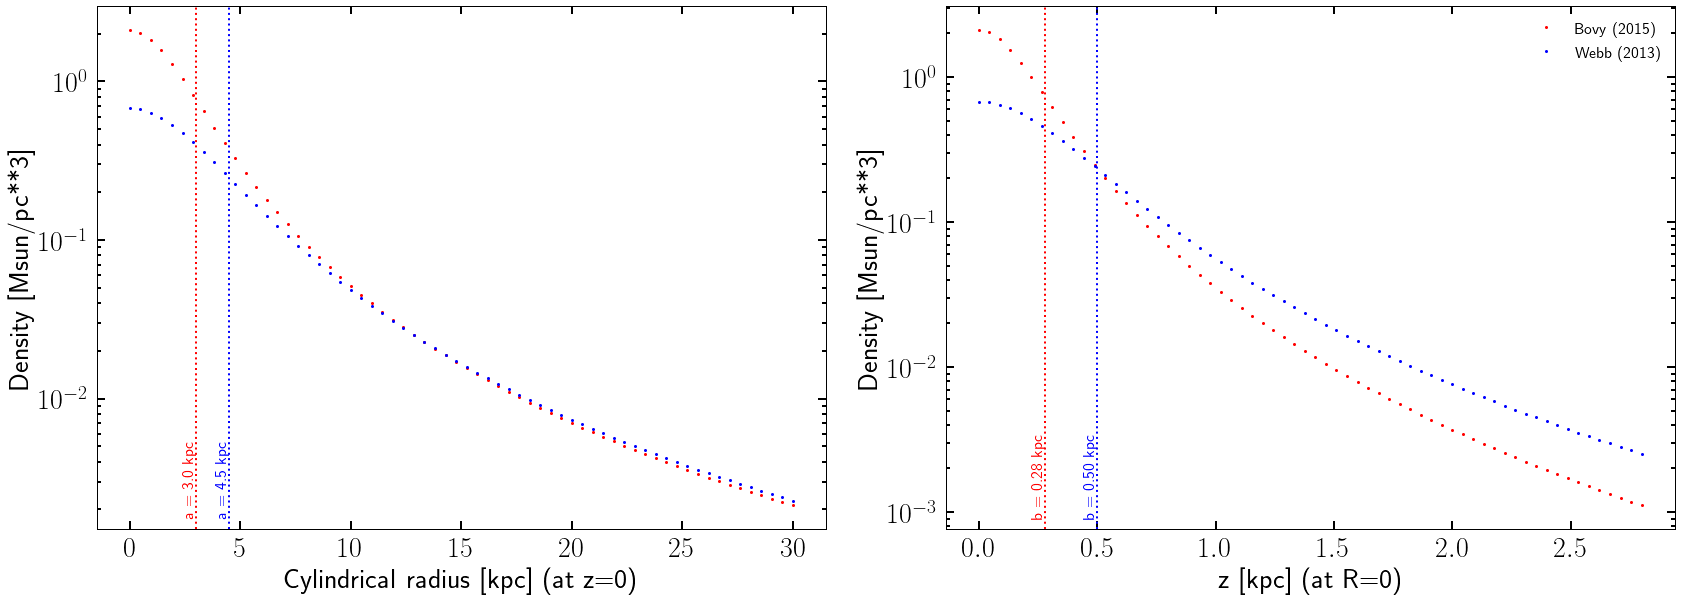

/usr/local/lib/python3.7/site-packages/galpy/util/bovy_plot.py:646: UserWarning: The following kwargs were not used by contour: 'aspect'
  linestyles=cntrls,origin=origin)



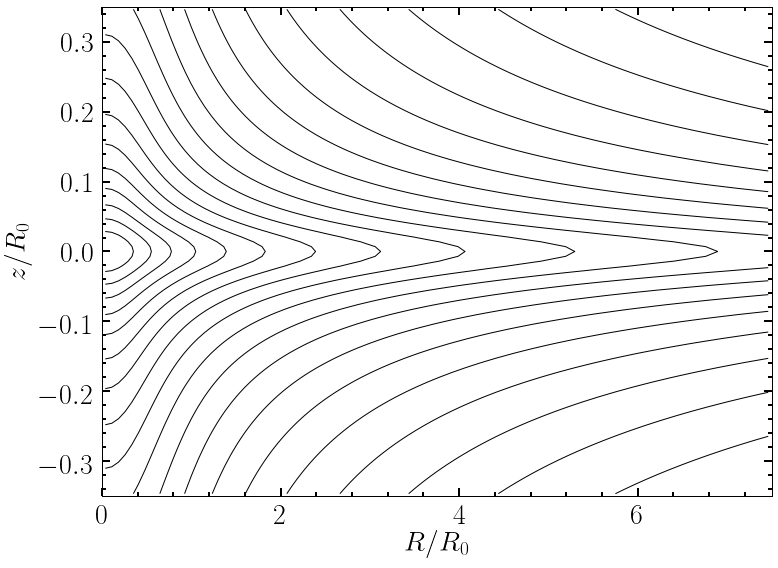

In [6]:
fig, (ax, ax2) = pyplot.subplots(1, 2, figsize=(24, 9))

for i, r in enumerate(numpy.linspace(0, 30, 64)):
    ax.plot(r, disk.dens(r*u.kpc, z=0*u.kpc)*to_msunpc3, "ro", label="Bovy (2015)" if i is 0 else "")
    ax.plot(r, disk_webb_2013.dens(r*u.kpc, z=0*u.kpc)*to_msunpc3, "bo", label="Webb (2013)" if i is 0 else "")

ax.set_xlabel("Cylindrical radius [kpc] (at z=0)")
ax.set_ylabel("Density [Msun/pc**3]")
# ax.set_xscale("log")
ax.set_yscale("log")

# a=3, so where is it?
ax.axvline(3.0, c="r", ls=":", lw=2)
ax.axvline(4.5, c="b", ls=":", lw=2)
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.text(3.0, 0.02, "a = 3.0 kpc", c="red", rotation=90, ha="right", va="bottom", fontsize=16, transform=trans)
ax.text(4.5, 0.02, "a = 4.5 kpc", c="blue", rotation=90, ha="right", va="bottom", fontsize=16, transform=trans)

for i, z in enumerate(numpy.linspace(0, 2.8, 64)):
    ax2.plot(z, disk.dens(0*u.kpc, z=z*u.kpc)*to_msunpc3, "ro", label="Bovy (2015)" if i is 0 else "")
    ax2.plot(z, disk_webb_2013.dens(0*u.kpc, z=z*u.kpc)*to_msunpc3, "bo", label="Webb (2013)" if i is 0 else "")

ax2.set_xlabel("z [kpc] (at R=0)")
ax2.set_ylabel("Density [Msun/pc**3]")
# ax2.set_xscale("log")
ax2.set_yscale("log")

# b=0.28, so where is it?
ax2.axvline(0.28, c="r", ls=":", lw=2)
ax2.axvline(0.5, c="b", ls=":", lw=2)
trans = matplotlib.transforms.blended_transform_factory(ax2.transData, ax2.transAxes)
ax2.text(0.28, 0.02, "b = 0.28 kpc", c="red", rotation=90, ha="right", va="bottom", fontsize=16, transform=trans)
ax2.text(0.50, 0.02, "b = 0.50 kpc", c="blue", rotation=90, ha="right", va="bottom", fontsize=16, transform=trans)
ax2.legend(loc="upper right", fontsize=16, frameon=False)

pyplot.tight_layout()
pyplot.show(fig)

disk.plotDensity(rmin=0*u.kpc, rmax=60*u.kpc, zmin=-2.8*u.kpc, zmax=2.8*u.kpc, nrs=101, nzs=101, ncontours=21, log=True, justcontours=True)
pyplot.show()

# What does $M(<r)$ of MWPotential2014 (Bovy 2015) look like?

In [7]:
verbose = False

radii = numpy.logspace(-2, 3, 64)
Mbulge = numpy.zeros(radii.shape)
Mdisk = numpy.zeros(radii.shape)
Mdm = numpy.zeros(radii.shape)
Mtot = numpy.zeros(radii.shape) 

# Calculate mass for different components of the potential
for i, r in enumerate(radii):
    Mbulge[i] = bulge.mass(r*u.kpc) * to_msun
    Mdisk[i] = disk.mass(r*u.kpc, z=100*u.kpc, forceint=True) * to_msun
    Mdm[i] = dm.mass(r*u.kpc) * to_msun
    Mtot[i] = Mbulge[i] + Mdisk[i] + Mdm[i]
    if verbose: print("{0:<5.2f}{1:<5.2f}{2:<5.2f}{3:<5.2f}".format(r, Mbulge[i], Mdisk[i], Mdm[i], Mtot[i]))
    

print(Mbulge[-1]/1e10)
print(Mdisk[-1]/1e10)
# But NFW does not converge, so that's why we pull R200 and M200 from the literature =)
print(Mdm[-1]/1e10)
print(Mtot[-1]/1e10)

0.450136537506545
6.7989054788588215
138.33582619789047
145.58486821425583


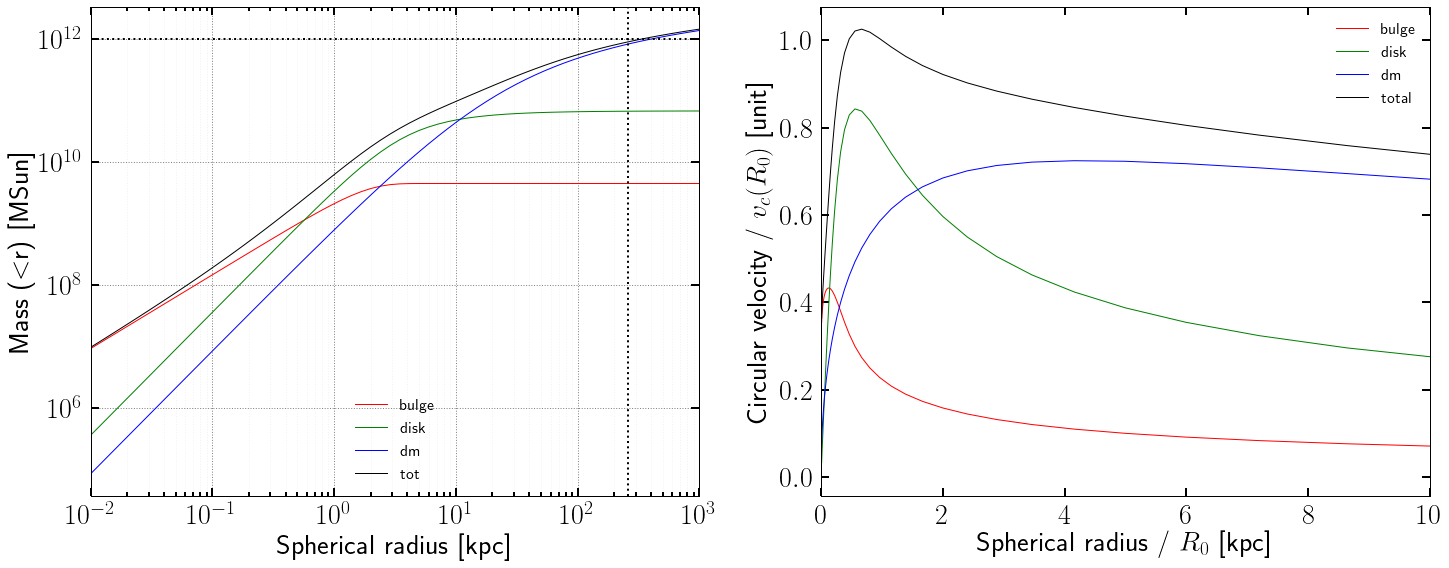

In [8]:
fig, (ax, ax2) = pyplot.subplots(1, 2, figsize=(24, 9))
    
ax.plot(radii, Mbulge, c="red", label="bulge")
ax.plot(radii, Mdisk, c="green", label="disk")
ax.plot(radii, Mdm, c="blue", label="dm")
ax.plot(radii, Mtot, c="black", label="tot")

# Indicate expected mass of the Galaxy to see if calculation makes sense
# Parel+ (2017) --> Rvir,MW = 261 kpc /w Mvir,MW = 1e12 O_o?
ax.axhline(1e12, c="k", ls=":", lw=2)
ax.axvline(261, c="k", ls=":", lw=2)

ax.set_xlim(1e-2, 1e3)
ax.set_xlabel("Spherical radius [kpc]")
ax.set_ylabel("Mass ($<$r) [MSun]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.tick_params("y", which="minor", direction="in", colors='r')
# ax.set_yticks(10**numpy.arange(5, 13, 0.5), minor=True)  # not logspaced minor ticks :/
ax.grid(color="grey", ls=":", lw=1, alpha=0.1, which="minor")
ax.grid(color="grey", ls=":", lw=1, alpha=1, which="major")
ax.legend(fontsize=16, loc="best", frameon=False)

from galpy.potential import vcirc
ax2.plot(radii, vcirc(bulge, radii), c="red", label="bulge")
ax2.plot(radii, vcirc(disk, radii), c="green", label="disk")
ax2.plot(radii, vcirc(dm, radii), c="blue", label="dm")
ax2.plot(radii, vcirc(MWPotential2014, radii), c="black", label="total")

ax2.set_xlabel("Spherical radius / $R_0$ [kpc]")
ax2.set_ylabel("Circular velocity / $v_c(R_0)$ [unit]")
# ax2.set_xscale("log")
# ax2.set_yscale("log")
ax2.set_xlim(0, 10)
ax2.legend(fontsize=16, loc="best", frameon=False)

pyplot.show(fig)

# Want to calculate derivative of potential

- Setup a grid in (R,z) coordinates (with sizes dR and dz).
- Calculate the mass density for the MWpotential2014 at each gridpoint (potential.evaluateDensities(pot,R,z) or something like that in galpy).
- Transform from galpy to physical units (bovy_cinversion.density_in_Msunpc3(_REFV0,_REFR0) or something like that in galpy)
- Multiply each gridpoint’s density with the volume of the cylindrical annulus, i.e. 2*pi*R*dR*dz (in units of pc^3), then you have the mass in each annulus.
- For each spherical r = sqrt(R^2+z^2) sum the masses of all annuli that fall into this half-sphere in the (R,z) plane.
- Plot M(<r) vs. r.
- Play around with dR and dz until you get the plot in 6. to converge.
- Use the plot in 6 to read off the enclosed masses for all the GCs pericenters.

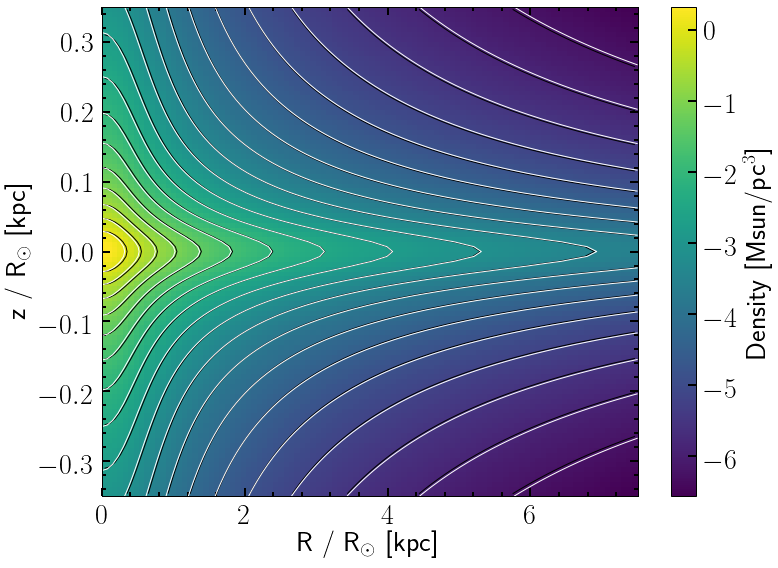

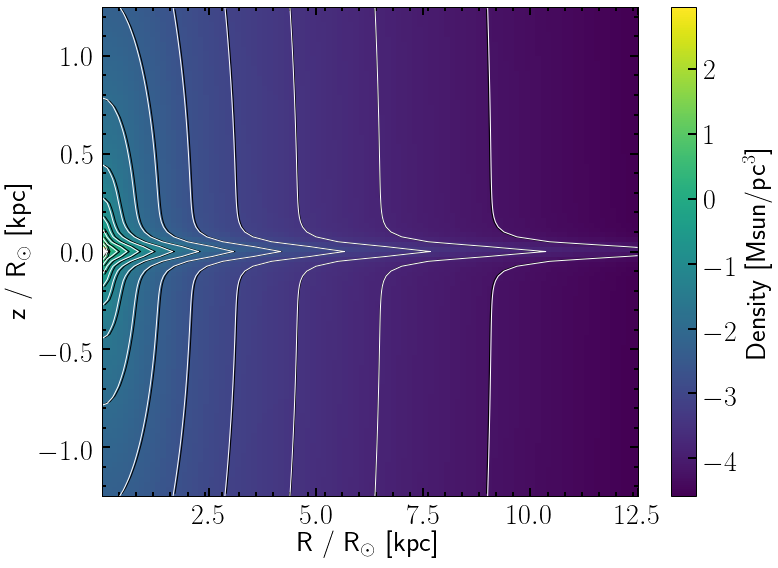

In [9]:
# Here we evaluate the density of the MWPotential2014 disk component and compare it against
# the built-in galpy plotDensities.

from galpy.potential import evaluateDensities, plotDensities
zs = numpy.linspace(-2.8/8., 2.8/8., 101)
Rs = numpy.linspace(0/8., 60/8., 101)
Rs, zs = numpy.meshgrid(Rs, zs)
rhoRz = evaluateDensities(MWPotential2014[1], Rs, zs) * to_msunpc3

disk.plotDensity(rmin=0*u.kpc, rmax=60*u.kpc, zmin=-2.8*u.kpc, zmax=2.8*u.kpc,
                 nrs=101, nzs=101, ncontours=21, log=True, justcontours=True)
fig, ax = pyplot.gcf(), pyplot.gca()

cax = ax.pcolormesh(Rs, zs, numpy.log10(rhoRz))
# levels copied from galpy plotDensities' call to bovy_dens2d, but I added log10 everywhere
levels = numpy.logspace(numpy.log10(numpy.nanmin(rhoRz)), numpy.log10(numpy.nanmax(rhoRz)), 21)
cntr = ax.contour(Rs, zs, numpy.log10(rhoRz), colors="white", linestyles="-", levels=numpy.log10(levels))
# print(cntr.levels)

cax = pyplot.colorbar(cax, ax=ax)
cax.ax.set_ylabel("Density [Msun/pc$^3$]")
ax.set_xlabel("R / R$_\odot$ [kpc]")
ax.set_ylabel("z / R$_\odot$ [kpc]")

pyplot.show()


# And now for bulge+disk+dm, and /w different zmin, zmax

from galpy.potential import evaluateDensities
zs = numpy.linspace(-10/8., 10/8., 101)
Rs = numpy.linspace(0.01/8., 100/8., 101)
Rs, zs = numpy.meshgrid(Rs, zs)
rhoRz = evaluateDensities(MWPotential2014, Rs, zs) * to_msunpc3

plotDensities(MWPotential2014, rmin=0.01*u.kpc, rmax=100*u.kpc, zmin=-10*u.kpc, zmax=10*u.kpc,
              nrs=101, nzs=101, ncontours=21, log=True, justcontours=True)
fig, ax = pyplot.gcf(), pyplot.gca()

cax = ax.pcolormesh(Rs, zs, numpy.log10(rhoRz))
# levels copied from galpy plotDensities' call to bovy_dens2d, but I added log10 everywhere
levels = numpy.logspace(numpy.log10(numpy.nanmin(rhoRz)), numpy.log10(numpy.nanmax(rhoRz)), 21)
cntr = ax.contour(Rs, zs, numpy.log10(rhoRz), colors="white", linestyles="-", levels=numpy.log10(levels))
# print(cntr.levels)

cax = pyplot.colorbar(cax, ax=ax)
cax.ax.set_ylabel("Density [Msun/pc$^3$]")
ax.set_xlabel("R / R$_\odot$ [kpc]")
ax.set_ylabel("z / R$_\odot$ [kpc]")

pyplot.show()

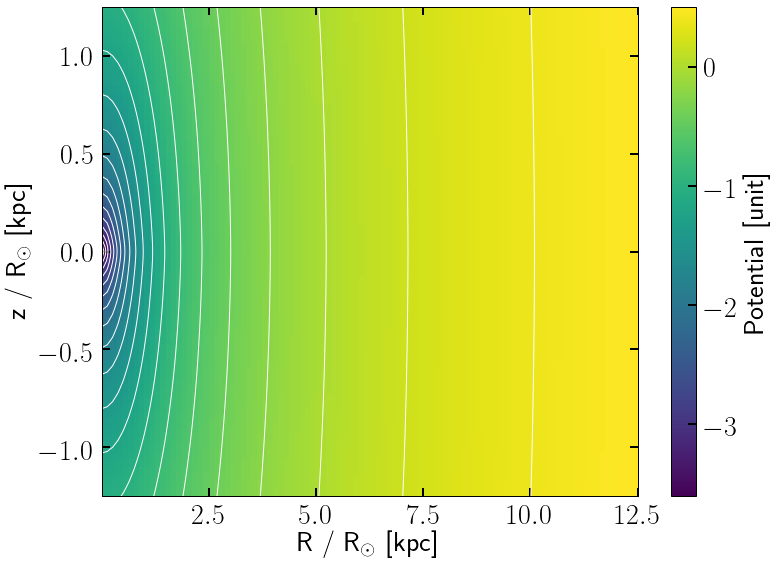

In [10]:
# The idea here was to tabulate potential(R,z), then get potential(r) from that,
# take first and second derivative. However, we have M(r) in spherical coordinates,
# so instead can just take potential of MW as -GM(r) / r, get derivates analytically.

from galpy.potential import evaluatePotentials

zs = numpy.linspace(-10/8., 10/8., 101)
Rs = numpy.linspace(0.1/8., 100/8., 101)
Rs, zs = numpy.meshgrid(Rs, zs)
potRz = evaluatePotentials(MWPotential2014, Rs, zs)
dV = 2*numpy.pi*Rs

fig, ax = pyplot.subplots()

cax = ax.pcolormesh(Rs, zs, potRz)
cntr = ax.contour(Rs, zs, potRz, colors="white", linestyles="-", levels=21)

cax = pyplot.colorbar(cax, ax=ax)
cax.ax.set_ylabel("Potential [unit]")
ax.set_xlabel("R / R$_\odot$ [kpc]")
ax.set_ylabel("z / R$_\odot$ [kpc]")

pyplot.show()


r = numpy.sqrt(Rs**2 + zs**2)
# Now how to get potential as a function of r?? O_o

In [11]:
potr = -const.G.to(u.m**3 / u.kg / u.s**2) * (Mtot*u.Msun).to(u.kg) / (radii*u.kpc).to(u.m)
dpotr_dr = const.G.to(u.m**3 / u.kg / u.s**2) * (Mtot*u.Msun).to(u.kg) / numpy.power( (radii*u.kpc).to(u.m), 2)
d2potr_dr2 = -2.0*const.G.to(u.m**3 / u.kg / u.s**2) * (Mtot*u.Msun).to(u.kg) / numpy.power( (radii*u.kpc).to(u.m), 3)

def rt_webb2013_eq3(Mgc, Rperi, debug=True):
    """
    @param Mgc: globular cluster mass; value only, given in Msun
    @param Rperi: pericenter radius of GC orbit; value only, given in kpc 
    """
    
    GM = const.G.to(u.m**3 / u.kg / u.s**2) * (Mgc*u.Msun).to(u.kg)
    
    iRperi, = numpy.where(radii < Rperi)
    potr_at_Rperi = potr[iRperi[-1]]  # m^2 s^-2
    dpotr_dr_at_Rperi = dpotr_dr[iRperi[-1]]  # m s^-2
    d2potr_dr2_at_Rperi = d2potr_dr2[iRperi[-1]]  # s^-2
    
    Omega_squared = dpotr_dr_at_Rperi / (Rperi*u.kpc).to(u.m)  # Webb+ 2013 eq. 4
    kappa_squared = 3*Omega_squared + d2potr_dr2_at_Rperi  # Webb+ 2013 eq. 5
    nu = 4 - kappa_squared / Omega_squared  # Webb+ 2013 eq. 6
    
    if debug:
        fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(36, 9))

        ax1.plot(radii, -potr, c="k", label="M(<r)")
        ax1.axhline(-potr_at_Rperi.value)
        ax1.axvline(Rperi)
        ax1.set_xlabel("Radius [kpc]")
        ax1.set_ylabel("-$\Phi_G(<r)$ [m$^2$ s$^{-2}$]")
        ax1.set_xscale("log")
        ax1.set_yscale("log")

        ax2.plot(radii, dpotr_dr, c="k")
        ax2.axhline(dpotr_dr_at_Rperi.value)
        ax2.axvline(Rperi)
        ax2.set_xlabel("Radius [kpc]")
        ax2.set_ylabel("d$\Phi_G(<r)$/d$r$ [m s$^{-2}$]")
        ax2.set_xscale("log")
        ax2.set_yscale("log")

        ax3.plot(radii, -d2potr_dr2, c="k")
        ax3.axhline(-d2potr_dr2_at_Rperi.value)
        ax3.axvline(Rperi)
        ax3.set_xlabel("Radius [kpc]")
        ax3.set_ylabel("-d$^2\Phi_G(<r)$/d$r^2$ [s$^{-2}$]")
        ax3.set_xscale("log")
        ax3.set_yscale("log")

        pyplot.show()

    return numpy.power(GM / (Omega_squared*nu), 1.0/3).to(u.parsec).value  # Webb+ 2013 eq. 3, or Bertin & Varri (2008) eq. 10

# Get all relevant data sorted

In [12]:
# 'R_Sun' > Distance from Sun (kiloparsecs)
# 'r_c' --> Core radius in arcmin [for a King profile, I assume]
# 'c' ----> King-model central concentration, c = log(r_t/r_c); a 'c' denotes a core-collapsed cluster

distance_kpc = MW_h96e10["R_Sun"]  # kpc
king_tidal_radius_arcmin = numpy.power(10, MW_h96e10["c"]) * MW_h96e10["r_c"]  # arcmin b/c r_c in arcmin
king_tidal_radius_parsec = (arcmin2parsec(king_tidal_radius_arcmin, distance_kpc) * u.parsec).to(u.parsec)

In [13]:
from data.parse_hilker_2019 import parse_hilker_2019_combined
from data.parse_hilker_2019 import parse_hilker_2019_orbits
hilker_combined = parse_hilker_2019_combined(logger, debug=True)
hilker_orbits = parse_hilker_2019_orbits(logger, debug=True)

data = []
not_in_hilker_orbits = []
not_in_harris = []
verbose = True
if verbose: 
    print("{0:<15s}{1:>10s}{2:>10s}{3:>10s}{4:>10s}{5:>10s}{6:>10s}{7:>10s}{8:>10s}{9:>10s}{10:>10s}".format(
        "GC", "Mass", "R_GC", "Rperi", "Rapo", "M(<Rperi)", "rt (H19)", "rt (1e12)", "rt (calc)", "rt (king)", "rt (webb)")
    )
for i, (gc_name, gc_mass, rgal, rt_hilker) in enumerate(zip(
        hilker_combined["Cluster"], hilker_combined["Mass"],
        hilker_combined["R_GC"], hilker_combined["rt"]
    )):
     
    imatch, = numpy.where(hilker_orbits["Cluster"] == gc_name)
    if len(imatch) == 1:
        Rperi = hilker_orbits["RPERI"][imatch][0]
        Rapo = hilker_orbits["RAP"][imatch][0]
    else:
        # print("{0} not in hilker_orbits".format(gc_name))
        not_in_hilker_orbits.append(gc_name)
        continue
    
    imatch_h96e10, = numpy.where(MW_h96e10["ID"] == 
        gc_name.replace("Ter", "Terzan").replace("Djor", "Djorg").encode("utf-8"))
    if len(imatch_h96e10) == 1:
        king_c = MW_h96e10["c"][imatch_h96e10][0]
        if numpy.isnan(king_c):
            not_in_harris.append(gc_name)
            continue
        king_r_c = MW_h96e10["r_c"][imatch_h96e10][0]
        distance_kpc = MW_h96e10["R_Sun"][imatch_h96e10][0]
        
        king_tidal_radius_arcmin = numpy.power(10, king_c) * king_r_c  # arcmin b/c r_c in arcmin
        king_tidal_radius_parsec = (arcmin2parsec(king_tidal_radius_arcmin, distance_kpc) * u.parsec).to(u.parsec).value
        # print(king_c, king_r_c, distance_kpc, king_tidal_radius_arcmin, king_tidal_radius_parsec)
    else:
        # print("{0} not in Harris (1996, 2010 ed.)".format(gc_name))
        not_in_harris.append(gc_name)
        continue
    
    # Here we simply plug in the distance to the center of the Galaxy, as per Spitzer 1987 eq. 1-33
    # However, the equation is valid for two point masses on a circular orbit. GC orbits aren't quite
    # circular, so according to TODO-ADD-REF the equation would still be valid if Rperi is used instead.
    # Furthermore, we need to use the enclosed mass of the Galaxy, i.e. Mgal(<Rperi). 
    iMgal_enclosed, = numpy.where(radii < Rperi)
    Menclosed = Mtot[iMgal_enclosed[-1]]  # Msun
    tidal_radius = numpy.power(gc_mass*(Rperi*1e3)**3/(2*Menclosed), 1.0/3)  # parsec
    tidal_radius_1e12 = numpy.power(gc_mass*(Rperi*1e3)**3/(2*1e12), 1.0/3)  # parsec
    
    eccentricity = (Rapo - Rperi) / (Rapo + Rperi)
    
    # F=0 at perigalacticon; F=1 at apogalacticon. Circular orbit always has F=0
    webb2013_F = (rgal - Rperi) / ( Rapo - Rperi)  # orbital phase, Webb+ 2013 eq. 7.
    
    # Webb+ 2013 ApJ 764 124, eq. 8
    webb2013_a, webb2013_b = 0.17, 4.1  # a +/- 0.03; b +/- 0.2
    webb2013_tidal_radius = tidal_radius * ( 1 + webb2013_a * webb2013_F * numpy.exp(webb2013_b * eccentricity) )
    webb2013_tidal_radius_1e12 = tidal_radius_1e12 * ( 1 + webb2013_a * webb2013_F * numpy.exp(webb2013_b * eccentricity) )
    
    bv08_tidal_radius = rt_webb2013_eq3(gc_mass, Rperi, debug=False)
    webb2013_eq8_tidal_radius = bv08_tidal_radius * ( 1 + webb2013_a * webb2013_F * numpy.exp(webb2013_b * eccentricity) )
    
    print("\n{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}".format(
        "rgal", "Rperi", "Rapo", "F", "E", "H19", "s87_corr",
        "1e12", "eq3", "eq8")
    )
    print("{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}{:<10.2f}".format(
        rgal, Rperi, Rapo, webb2013_F, eccentricity, rt_hilker, webb2013_tidal_radius,
        webb2013_tidal_radius_1e12, bv08_tidal_radius, webb2013_eq8_tidal_radius)
    )
#     if verbose: 
#         print("{0:<15s}{1:>10.2e}{2:>10.2f}{3:>10.2f}{4:>10.2f}{5:>10.2e}{6:>10.2f}{7:>10.2f}{8:>10.2f}{9:>10.2f}{10:>10.2f}".format(
#             gc_name, gc_mass, rgal, Rperi, Rapo, Menclosed, rt_hilker, tidal_radius_1e12, tidal_radius, king_tidal_radius_parsec, webb2013_tidal_radius)
#         )
    
    data.append([tidal_radius_1e12, tidal_radius, rt_hilker, Rperi, Rapo, gc_mass, Menclosed,
                 king_tidal_radius_parsec, bv08_tidal_radius, webb2013_eq8_tidal_radius])
    
    # if i > 10: break
data = numpy.array(data)
print("\nHave {0} GCs in all data sets\n".format(len(data)))
print("Not in hilker_orbits: {0}".format(not_in_hilker_orbits))
print("Not in harris: {0}, but possibly also {1}".format(not_in_harris, not_in_hilker_orbits))

GC                   Mass      R_GC     Rperi      Rapo M(<Rperi)  rt (H19) rt (1e12) rt (calc) rt (king) rt (webb)

rgal      Rperi     Rapo      F         E         H19       s87_corr  1e12      eq3       eq8       
7.78      5.46      7.44      1.17      0.15      119.31    145.59    54.35     85.50     117.45    

rgal      Rperi     Rapo      F         E         H19       s87_corr  1e12      eq3       eq8       
13.17     3.33      13.01     1.02      0.59      98.54     126.49    38.70     32.84     97.23     

rgal      Rperi     Rapo      F         E         H19       s87_corr  1e12      eq3       eq8       
10.00     1.05      12.48     0.78      0.84      110.38    167.84    30.33     25.88     135.88    

rgal      Rperi     Rapo      F         E         H19       s87_corr  1e12      eq3       eq8       
36.05     17.64     53.27     0.52      0.50      38.14     52.71     27.13     23.50     39.70     

rgal      Rperi     Rapo      F         E         H19       s87_corr  1

rgal      Rperi     Rapo      F         E         H19       s87_corr  1e12      eq3       eq8       
1.17      0.18      1.12      1.05      0.72      9.06      28.98     2.05      4.96      22.16     

rgal      Rperi     Rapo      F         E         H19       s87_corr  1e12      eq3       eq8       
5.38      2.04      5.43      0.99      0.45      37.88     47.55     12.41     19.68     40.86     

rgal      Rperi     Rapo      F         E         H19       s87_corr  1e12      eq3       eq8       
1.88      0.41      1.45      1.41      0.56      13.93     41.71     4.66      10.24     34.58     

rgal      Rperi     Rapo      F         E         H19       s87_corr  1e12      eq3       eq8       
1.76      0.53      1.95      0.87      0.57      21.90     46.65     5.73      14.25     36.20     

rgal      Rperi     Rapo      F         E         H19       s87_corr  1e12      eq3       eq8       
5.30      2.52      5.14      1.06      0.34      49.40     59.14     16.76     28.59  

In [14]:
imismatch, = numpy.where(hilker_combined["Cluster"] != hilker_orbits["Cluster"])
print(hilker_combined["Cluster"][imismatch])
print(hilker_orbits["Cluster"][imismatch])

['Liller 1' 'NGC 6522' 'Ter 10' '2MASS-GC01' 'ESO 280-SC06' 'NGC 6553'
 '2MASS-GC02' 'NGC 6558' 'IC 1276' 'Ter 12' 'NGC 6569' 'BH 261' 'NGC 6584']
['Lil 1' 'Ter 10' 'NGC 6522' 'ESO 280-SC06' 'NGC 6553' '2MASS-GC02'
 'NGC 6558' 'IC 1276' 'Ter 12' 'NGC 6569' 'BH 261' 'NGC 6584' 'Mercer 5']


# What does the distribution of log10(Rperi) and log10(rt) log like?

Observed     mean, std: 37.54, 27.80
H19          mean, std: 77.30, 79.67
W13 eq8      mean, std: 83.55, 87.29


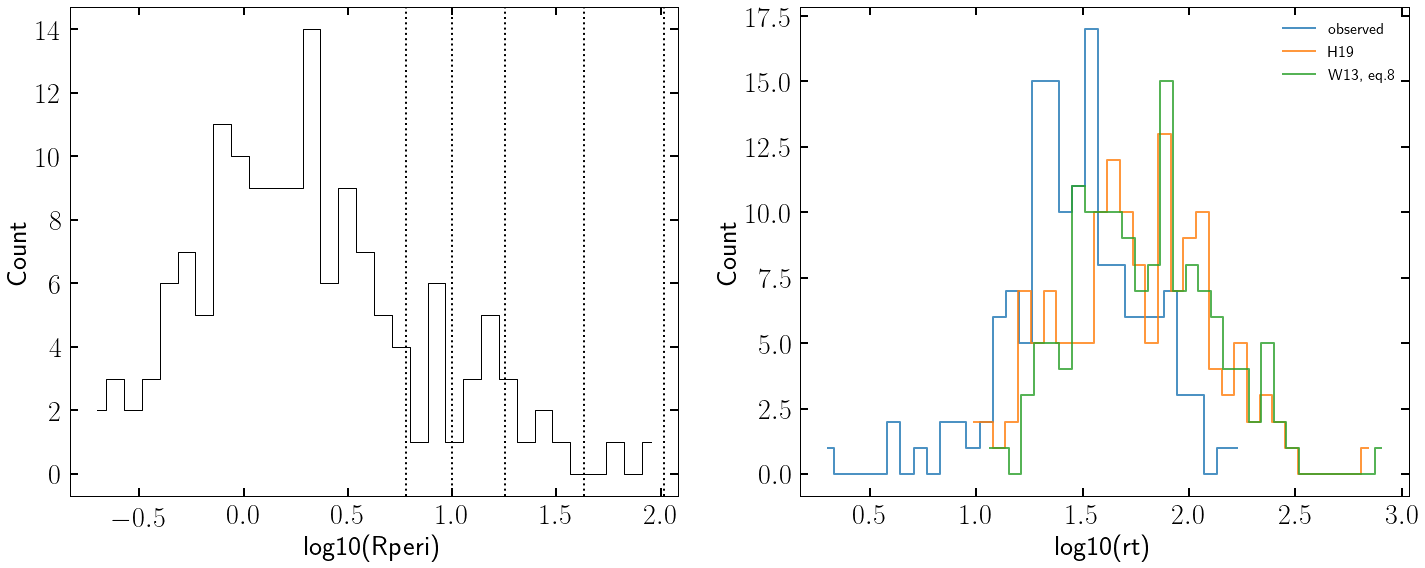

In [15]:
fig, (ax, ax1) = pyplot.subplots(1, 2, figsize=(24, 9))

# tidal_radius_1e12, tidal_radius, rt_hilker, Rperi, Rapo, Mgc, Menclosed, king_tidal_radius_parsec, bv08_tidal_radius, webb2013_eq8_tidal_radius
counts, edges = numpy.histogram(numpy.log10(data[:,3]), bins=32)
ax.plot((edges[1:]+edges[:-1])/2, counts, drawstyle="steps-mid", c="k")
# indicate models Rperi used in Webb+ 2013
ax.axvline(numpy.log10(6), c="k", ls=":", lw=2)
ax.axvline(numpy.log10(10), c="k", ls=":", lw=2)
ax.axvline(numpy.log10(18), c="k", ls=":", lw=2)
ax.axvline(numpy.log10(43), c="k", ls=":", lw=2)
ax.axvline(numpy.log10(104), c="k", ls=":", lw=2)
ax.set_xlabel("log10(Rperi)")
ax.set_ylabel("Count")


# tidal_radius_1e12, tidal_radius, rt_hilker, Rperi, Rapo, Mgc, Menclosed, king_tidal_radius_parsec, bv08_tidal_radius, webb2013_eq8_tidal_radius
print("Observed     mean, std: {0:.2f}, {1:.2f}".format(numpy.mean(data[:,7]), numpy.std(data[:,7]) ))
counts, edges = numpy.histogram(numpy.log10(data[:,7]), bins=32)
ax1.plot((edges[1:]+edges[:-1])/2, counts, drawstyle="steps-mid", lw=2, ls="-", alpha=0.8, label="observed")

# print("Mg=1e12      mean, std: {0:.2f}, {1:.2f}".format(numpy.mean(data[:,0]), numpy.std(data[:,0]) ))
# counts, edges = numpy.histogram(numpy.log10(data[:,0]), bins=32)
# ax1.plot((edges[1:]+edges[:-1])/2, counts, drawstyle="steps-mid", lw=2, ls="-", alpha=0.8, label="calculated /w Mg = 1e12")

# print("Mg=M(<Rperi) mean, std: {0:.2f}, {1:.2f}".format(numpy.mean(data[:,1]), numpy.std(data[:,1]) ))
# counts, edges = numpy.histogram(numpy.log10(data[:,1]), bins=32)
# ax1.plot((edges[1:]+edges[:-1])/2, counts, drawstyle="steps-mid", lw=2, ls="-", alpha=0.8, label="calculated /w Mg = Menc")

print("H19          mean, std: {0:.2f}, {1:.2f}".format(numpy.mean(data[:,2]), numpy.std(data[:,2]) ))
counts, edges = numpy.histogram(numpy.log10(data[:,2]), bins=32)
ax1.plot((edges[1:]+edges[:-1])/2, counts, drawstyle="steps-mid", lw=2, ls="-", alpha=0.8, label="H19")

# print("W13 eq3      mean, std: {0:.2f}, {1:.2f}".format(numpy.mean(data[:,8]), numpy.std(data[:,8]) ))
# counts, edges = numpy.histogram(numpy.log10(data[:,8]), bins=32)
# ax1.plot((edges[1:]+edges[:-1])/2, counts, drawstyle="steps-mid", lw=2, ls="-", alpha=0.8, label="W13, eq.3")

print("W13 eq8      mean, std: {0:.2f}, {1:.2f}".format(numpy.mean(data[:,9]), numpy.std(data[:,9]) ))
counts, edges = numpy.histogram(numpy.log10(data[:,9]), bins=32)
ax1.plot((edges[1:]+edges[:-1])/2, counts, drawstyle="steps-mid", lw=2, ls="-", alpha=0.8, label="W13, eq.8")

ax1.set_xlabel("log10(rt)")
ax1.set_ylabel("Count")
ax1.legend(fontsize=16, frameon=False)

pyplot.show()

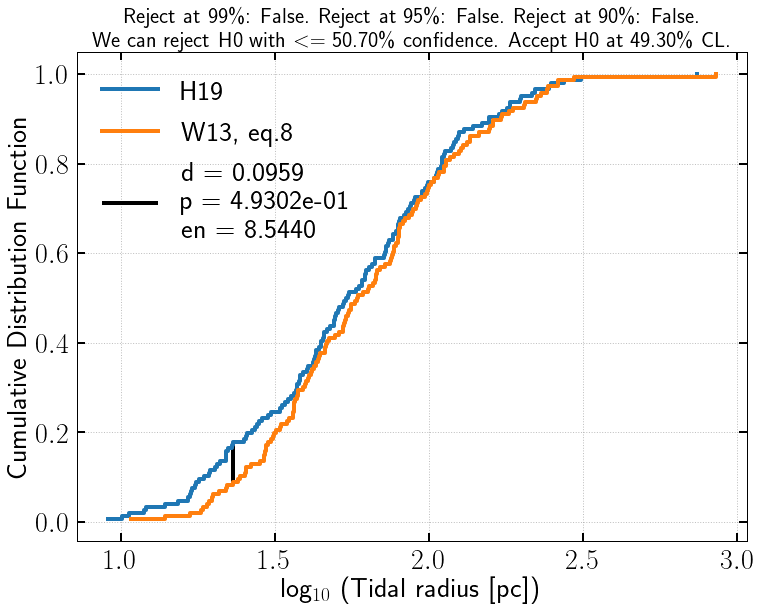

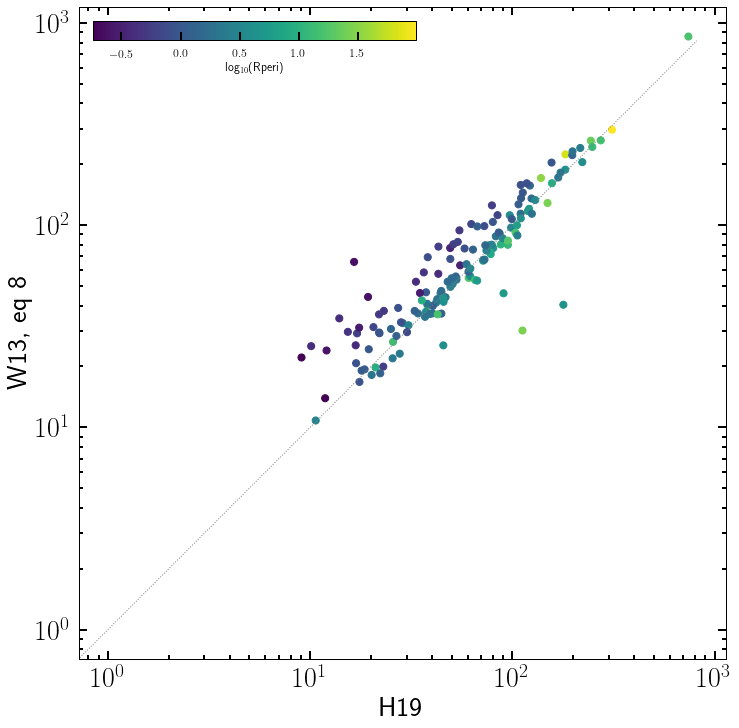

In [16]:
# Did I calculate tidal radius correctly (i.e. is my calculation of Webb 2013 eq. 8 consistent with H19)?
# Note that we use different Milky Way mass model as H19! 

from ks_test import ks_test, plot_ks_test
xvals, n1, n2, cdf1, cdf2, d, dbin, en, prob = ks_test(numpy.log10(data[:,2]), numpy.log10(data[:,9]))
fig = plot_ks_test(xvals, n1, cdf1, cdf2, d, dbin, en, prob, "H19", "W13, eq.8 ", "Ding", "log$_{10}$ (Tidal radius [pc])")
# ax = fig.gca(); ax.set_xscale("log")
pyplot.show(fig)

# tidal_radius_1e12, tidal_radius, rt_hilker, Rperi, Rapo, Mgc, Menclosed, king_tidal_radius_parsec, bv08_tidal_radius, webb2013_eq8_tidal_radius
fig, ax = pyplot.subplots(1, 1, figsize=(12, 12))
ax.scatter(data[:,2], data[:,9], c=numpy.log10(data[:,3]), s=50, cmap="viridis")

x = numpy.arange(1.1*numpy.max(hilker_combined["rt"]))
ax.plot(x, x, c="grey", lw=1, ls=":")
ax.set_xlabel("H19")
ax.set_ylabel("W13, eq 8")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_aspect("equal")

cax_xlabel = "Rperi"
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax, width="50%", height="3%", loc="upper left") 
cax = pyplot.colorbar(ax.get_children()[0], cax=cbaxes, orientation="horizontal")
cax.ax.set_xlabel("log$_{{10}}$({0})".format(cax_xlabel), fontsize=12)
cax.ax.tick_params(axis="both", which="major", labelsize=12)

# What does the plot /w calculated tidal radius for Mg=1e12 look like when colorcoded by Rperi? 

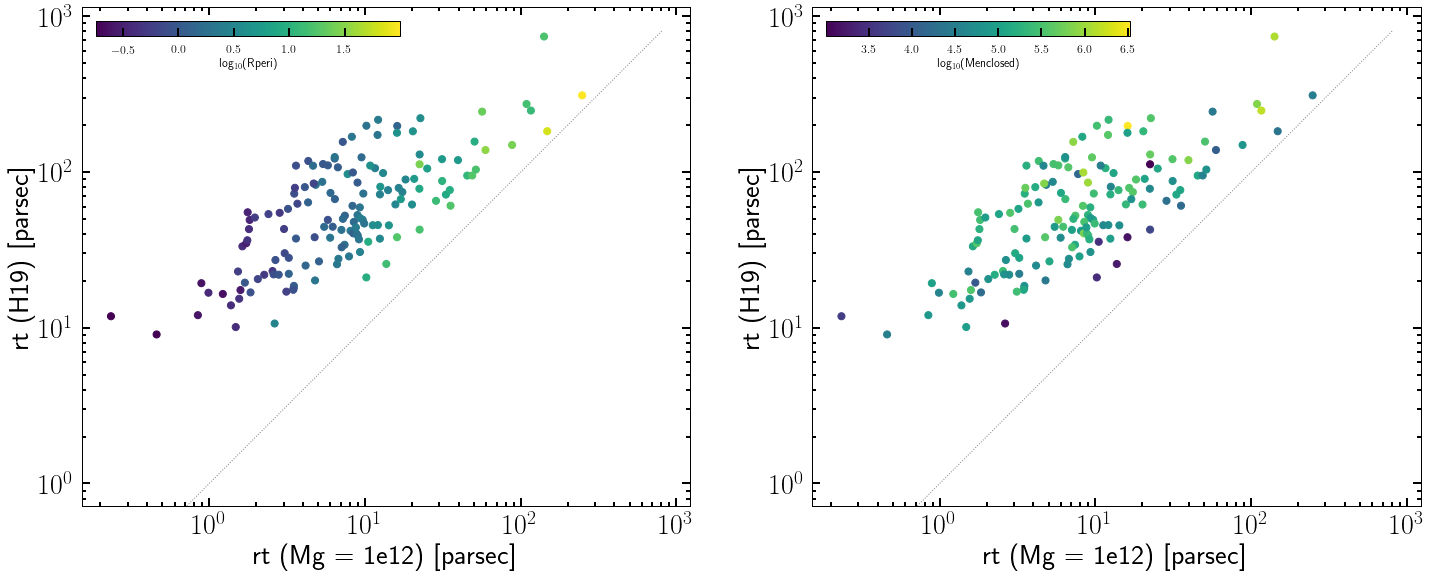

In [17]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(24, 12))

# tidal_radius_1e12, tidal_radius, rt_hilker, Rperi, Rapo, Menclosed, king_tidal_radius_parsec
ax1.scatter(data[:,0], data[:,2], c=numpy.log10(data[:,3]), s=50, cmap="viridis")
ax2.scatter(data[:,0], data[:,2], c=numpy.log10(data[:,5]), s=50, cmap="viridis")

for ax, cax_xlabel in zip([ax1, ax2], ["Rperi", "Menclosed"]):
    x = numpy.arange(1.1*numpy.max(hilker_combined["rt"]))
    ax.plot(x, x, c="grey", lw=1, ls=":")
    ax.set_xlabel("rt (Mg = 1e12) [parsec]")
    ax.set_ylabel("rt (H19) [parsec]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_aspect("equal")

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    cbaxes = inset_axes(ax, width="50%", height="3%", loc="upper left") 
    cax = pyplot.colorbar(ax.get_children()[0], cax=cbaxes, orientation="horizontal")
    cax.ax.set_xlabel("log$_{{10}}$({0})".format(cax_xlabel), fontsize=12)
    cax.ax.tick_params(axis="both", which="major", labelsize=12)

pyplot.show()

# What does rt_h19 vs. rt_calculated look like when using Mgal(<Rperi)?

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



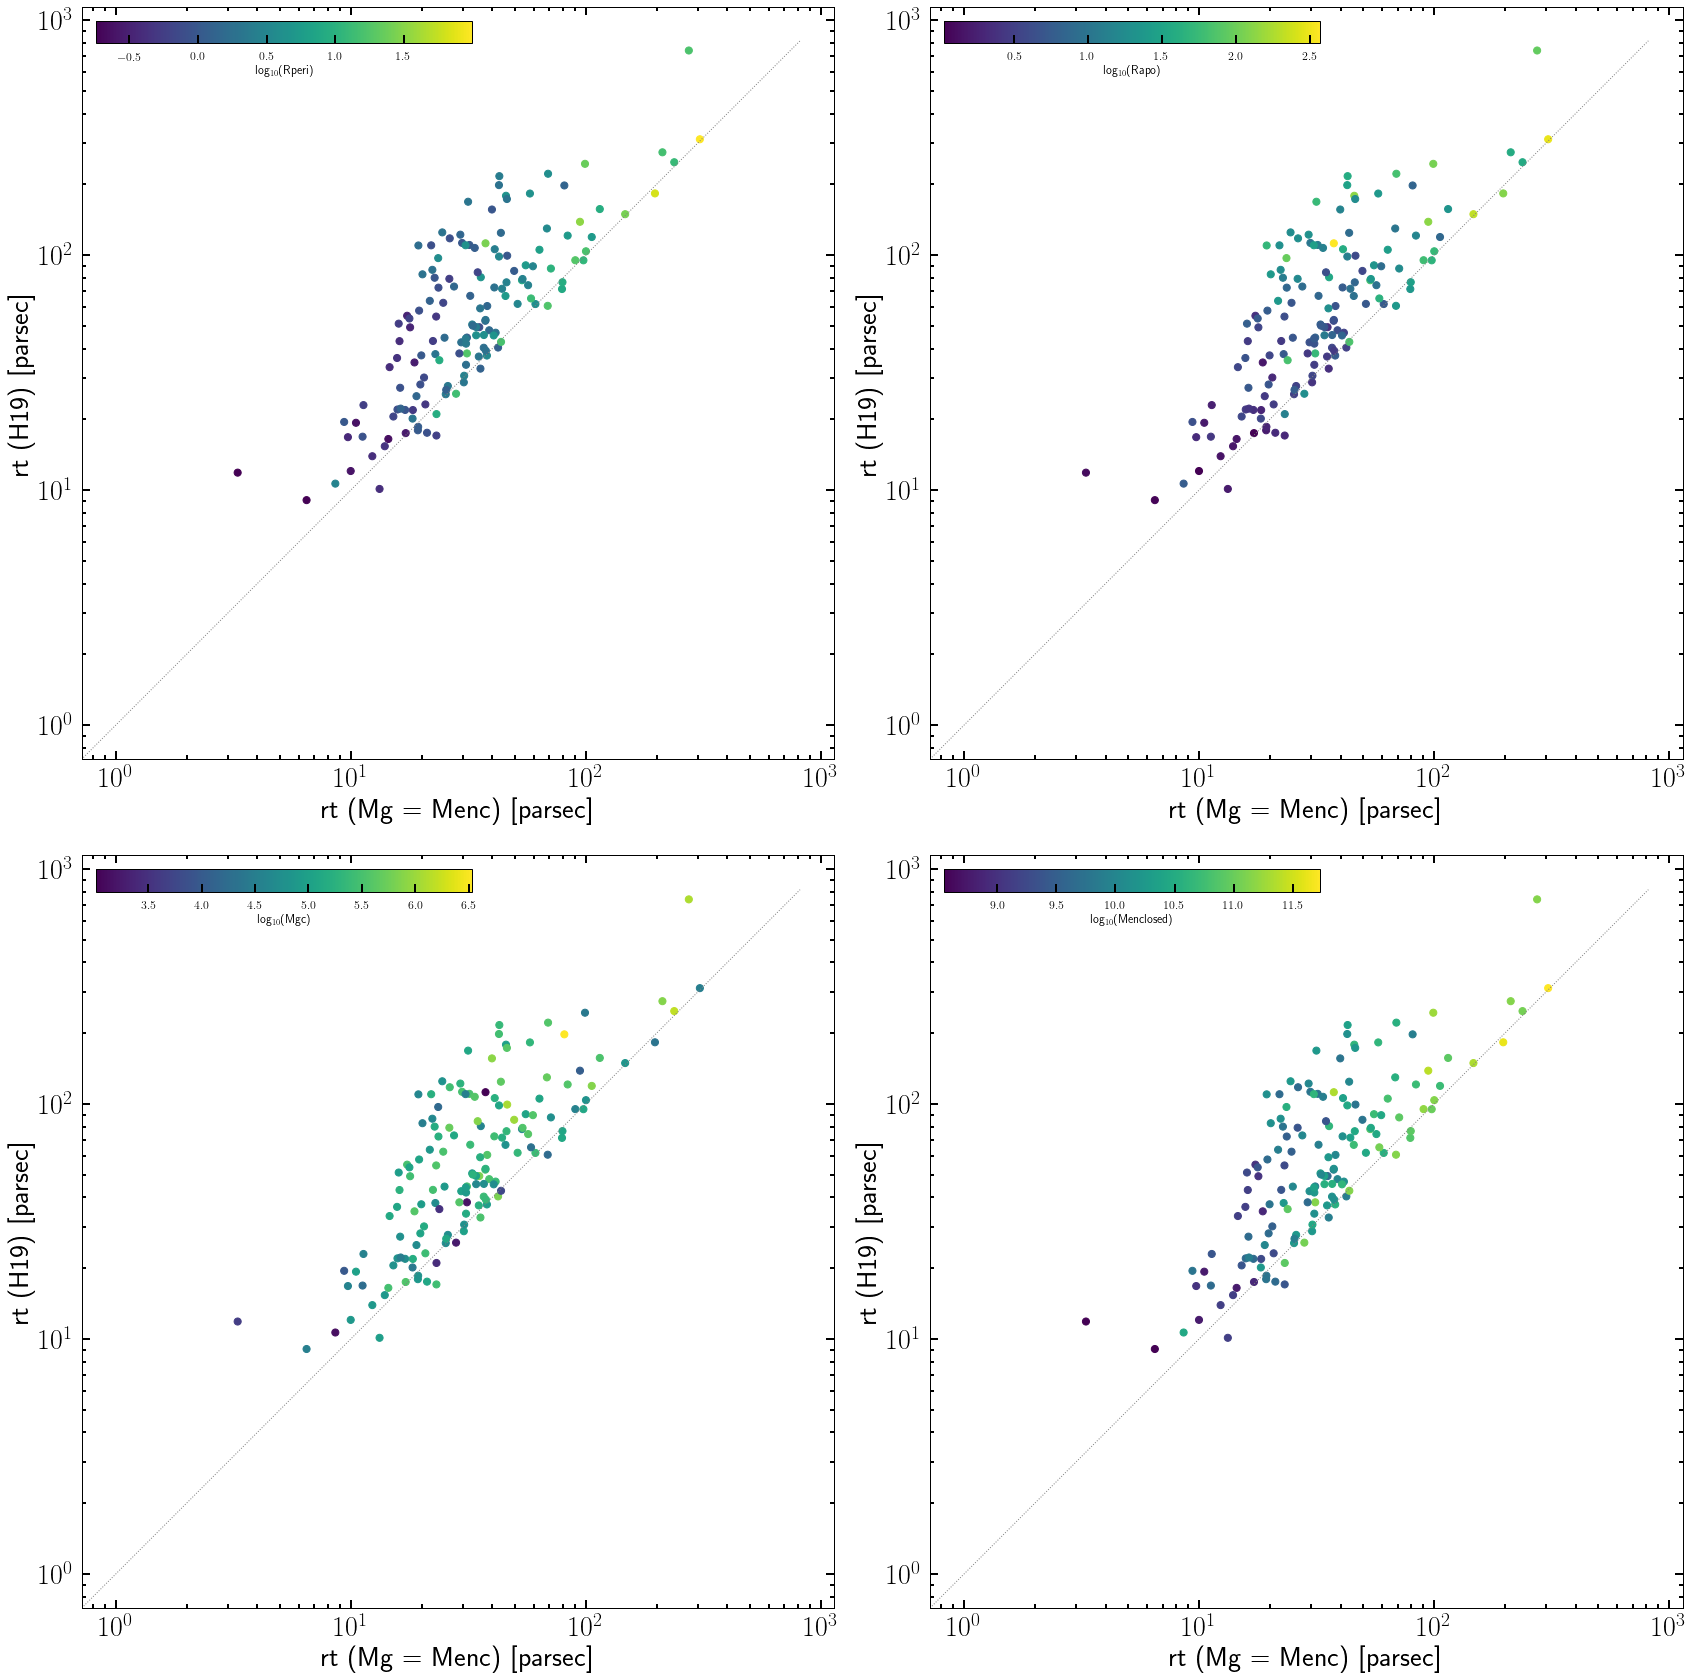

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = pyplot.subplots(2, 2, figsize=(24, 24))

# tidal_radius_1e12, tidal_radius, rt_hilker, Rperi, Rapo, Mgc, Menclosed, king_tidal_radius_parsec
ax1.scatter(data[:,1], data[:,2], c=numpy.log10(data[:,3]), s=50, cmap="viridis")
ax2.scatter(data[:,1], data[:,2], c=numpy.log10(data[:,4]), s=50, cmap="viridis")
ax3.scatter(data[:,1], data[:,2], c=numpy.log10(data[:,5]), s=50, cmap="viridis")
ax4.scatter(data[:,1], data[:,2], c=numpy.log10(data[:,6]), s=50, cmap="viridis")

for ax, cax_xlabel in zip([ax1, ax2, ax3, ax4], ["Rperi", "Rapo", "Mgc", "Menclosed"]):
    x = numpy.arange(1.1*numpy.max(hilker_combined["rt"]))
    ax.plot(x, x, c="grey", lw=1, ls=":")
    ax.set_xlabel("rt (Mg = Menc) [parsec]")
    ax.set_ylabel("rt (H19) [parsec]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_aspect("equal")

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    cbaxes = inset_axes(ax, width="50%", height="3%", loc="upper left") 
    cax = pyplot.colorbar(ax.get_children()[0], cax=cbaxes, orientation="horizontal")
    cax.ax.set_xlabel("log$_{{10}}$({0})".format(cax_xlabel), fontsize=12)
    cax.ax.tick_params(axis="both", which="major", labelsize=12)

pyplot.tight_layout()
pyplot.show()

# What does rt_king vs. rt_calculated look like?

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



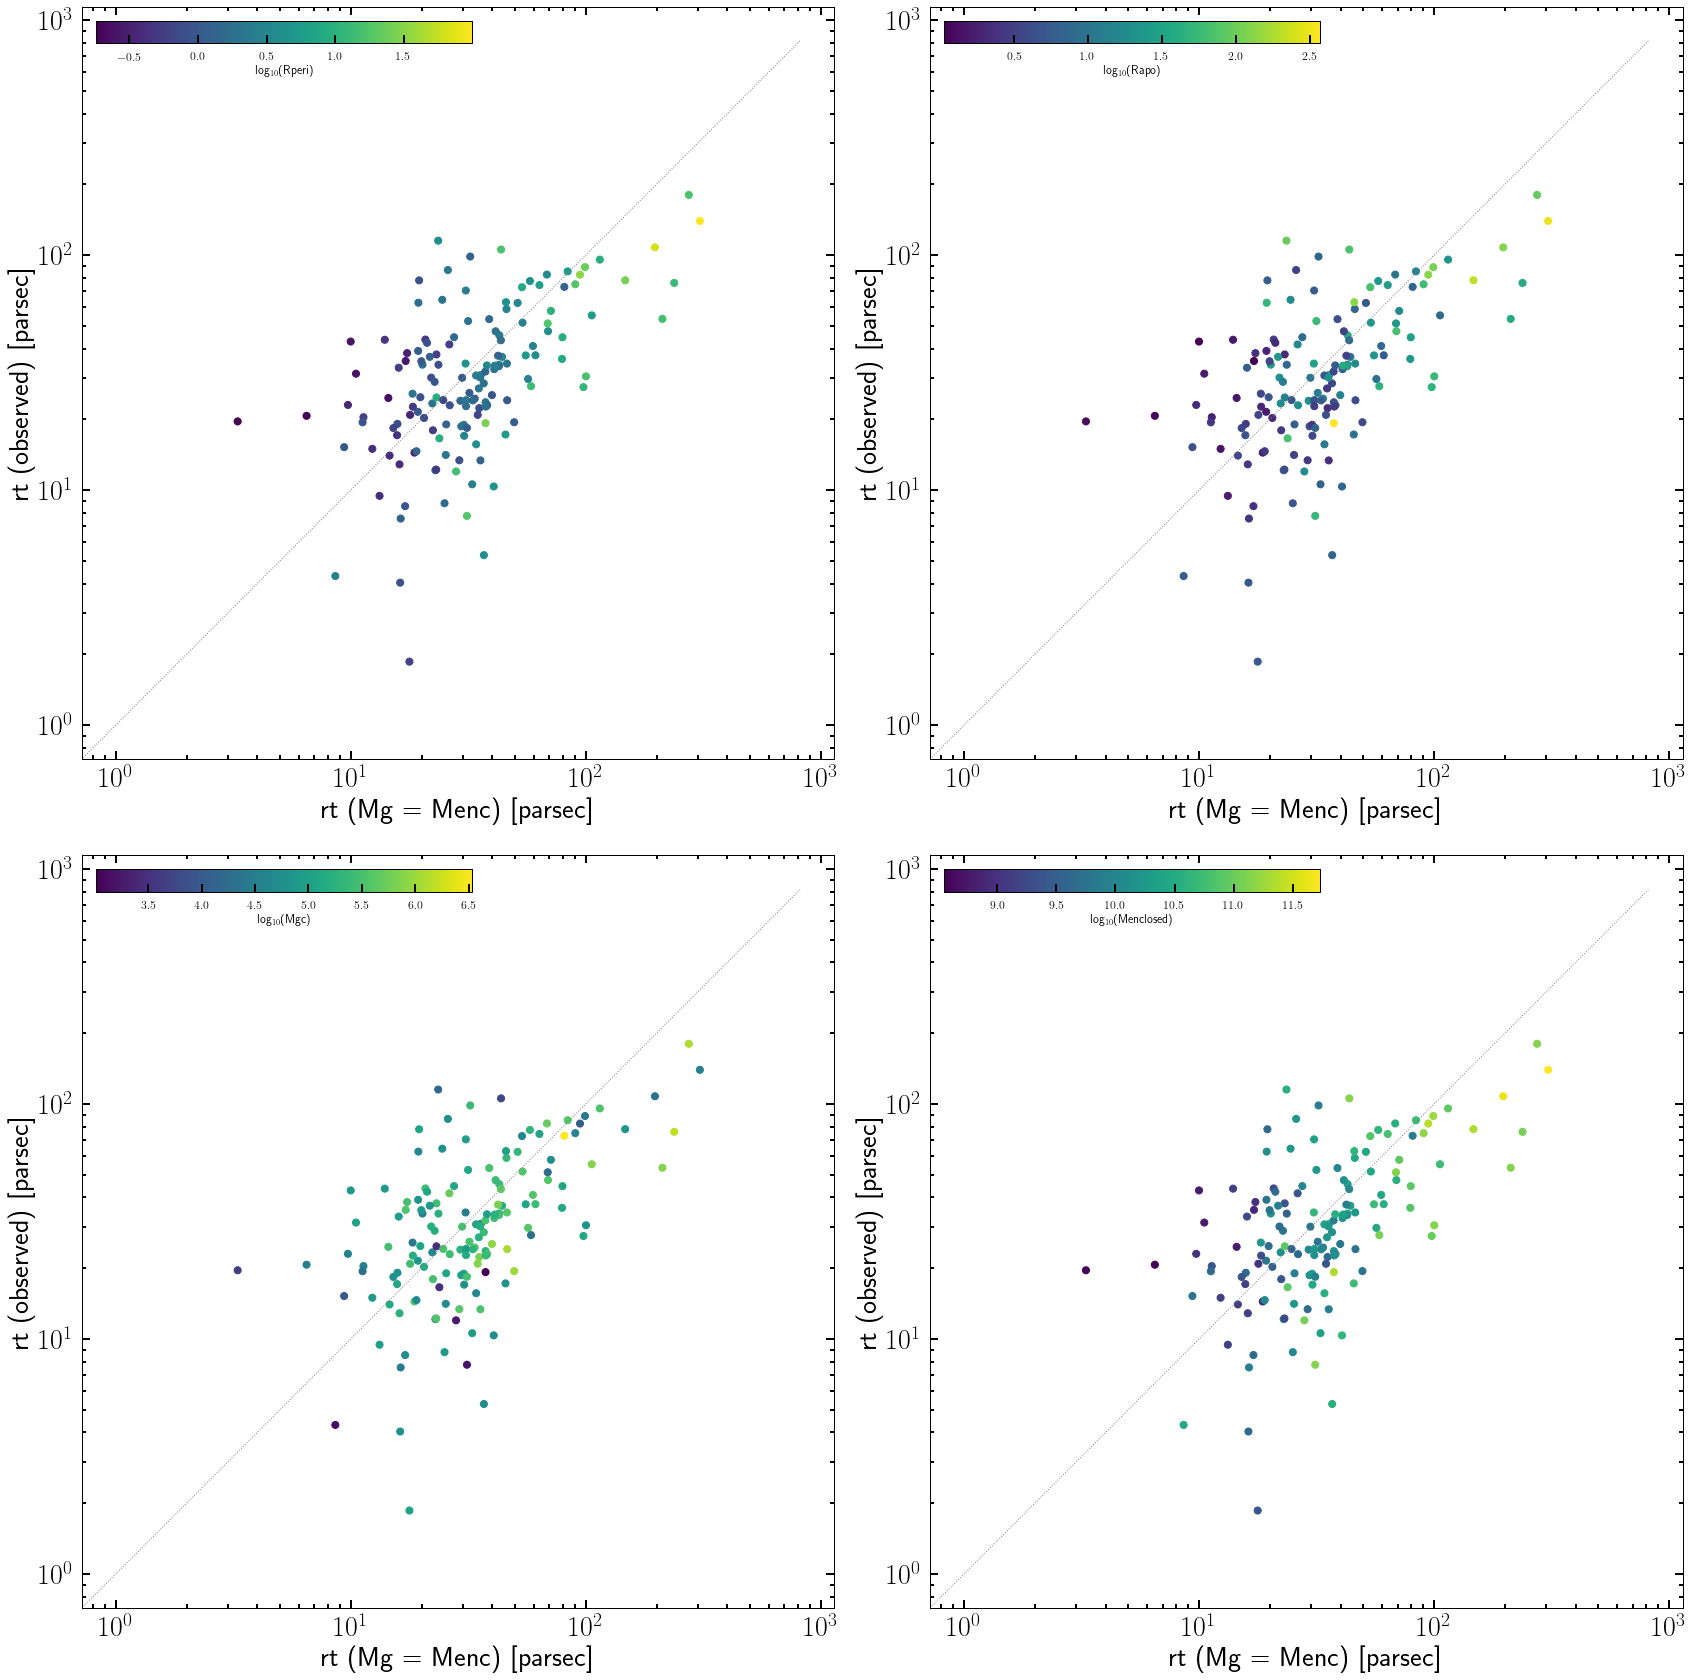

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = pyplot.subplots(2, 2, figsize=(24, 24))

# tidal_radius_1e12, tidal_radius, rt_hilker, Rperi, Rapo, Mgc, Menclosed, king_tidal_radius_parsec
ax1.scatter(data[:,1], data[:,7], c=numpy.log10(data[:,3]), s=50, cmap="viridis")
ax2.scatter(data[:,1], data[:,7], c=numpy.log10(data[:,4]), s=50, cmap="viridis")
ax3.scatter(data[:,1], data[:,7], c=numpy.log10(data[:,5]), s=50, cmap="viridis")
ax4.scatter(data[:,1], data[:,7], c=numpy.log10(data[:,6]), s=50, cmap="viridis")

for ax, cax_xlabel in zip([ax1, ax2, ax3, ax4], ["Rperi", "Rapo", "Mgc", "Menclosed"]):
    x = numpy.arange(1.1*numpy.max(hilker_combined["rt"]))
    ax.plot(x, x, c="grey", lw=1, ls=":")
    ax.set_xlabel("rt (Mg = Menc) [parsec]")
    ax.set_ylabel("rt (observed) [parsec]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_aspect("equal")

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    cbaxes = inset_axes(ax, width="50%", height="3%", loc="upper left") 
    cax = pyplot.colorbar(ax.get_children()[0], cax=cbaxes, orientation="horizontal")
    cax.ax.set_xlabel("log$_{{10}}$({0})".format(cax_xlabel), fontsize=12)
    cax.ax.tick_params(axis="both", which="major", labelsize=12)

pyplot.tight_layout()
pyplot.show()

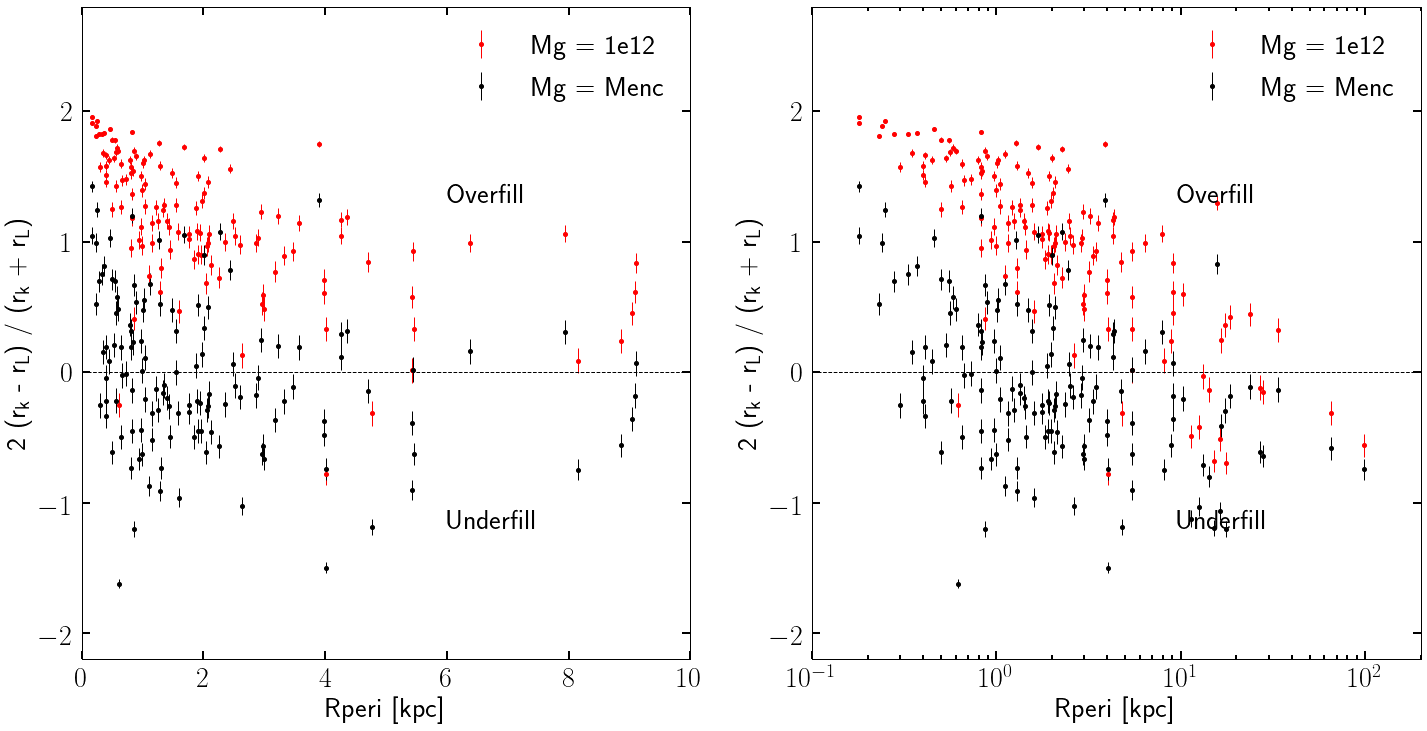

In [20]:
# Attempt to reproduce Webb+ 2013 ApJ 764 124 Fig. 1

fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(24, 12))

for ax in [ax1, ax2]:
    # tidal_radius_1e12, tidal_radius, rt_hilker, Rperi, Rapo, Mgc, Menclosed, king_tidal_radius_parsec
    r_k = data[:,7]  # fitted King (1962) radius from Harris (1996, 2010 ed.)
    r_t_1e12 = data[:,0]  # limiting radius as calculated, assuming Mg = 1e12
    r_t = data[:,1]  # limiting radius as calculated, assuming Mg = 1e12
    # r_l = data[:,2]  # limiting radius as calculated by Hilker (using eq. 8 of Webb+ 2013 ApJ 764 124)
    ratio_1e12 = 2*(r_k - r_t_1e12)/(r_k + r_t_1e12)
    ratio_1e12_err = 2*(r_k*1.1 - r_t_1e12)/(r_k*1.1 + r_t_1e12)
    ratio_Menc = 2*(r_k - r_t)/(r_k + r_t)
    ratio_Menc_err = 2*(r_k*1.1 - r_t)/(r_k*1.1 + r_t)
    ax.errorbar(data[:,3], ratio_1e12, yerr=ratio_1e12_err-ratio_1e12, marker="o", ls="", c="r", ms=4, label="Mg = 1e12")
    ax.errorbar(data[:,3], ratio_Menc, yerr=ratio_Menc_err-ratio_Menc, marker="o", ls="", c="k", ms=4, label="Mg = Menc")
    
    ax.axhline(0, ls="--", lw=1, c="k")
    ax.text(0.6, 0.2, "Underfill", c="k", transform=ax.transAxes)
    ax.text(0.6, 0.7, "Overfill", c="k", transform=ax.transAxes)

    ax.set_ylim(-2.2, 2.8)
    ax.set_xlabel("Rperi [kpc]")
    ax.set_ylabel("2 (r$_\\text{k}$ - r$_\\text{L}$) / (r$_\\text{k}$ + r$_\\text{L}$)")
    ax.legend(frameon=False)
    
ax1.set_xlim(0, 10)
ax2.set_xlim(0.1, 200)
ax2.set_xscale("log")

pyplot.show()

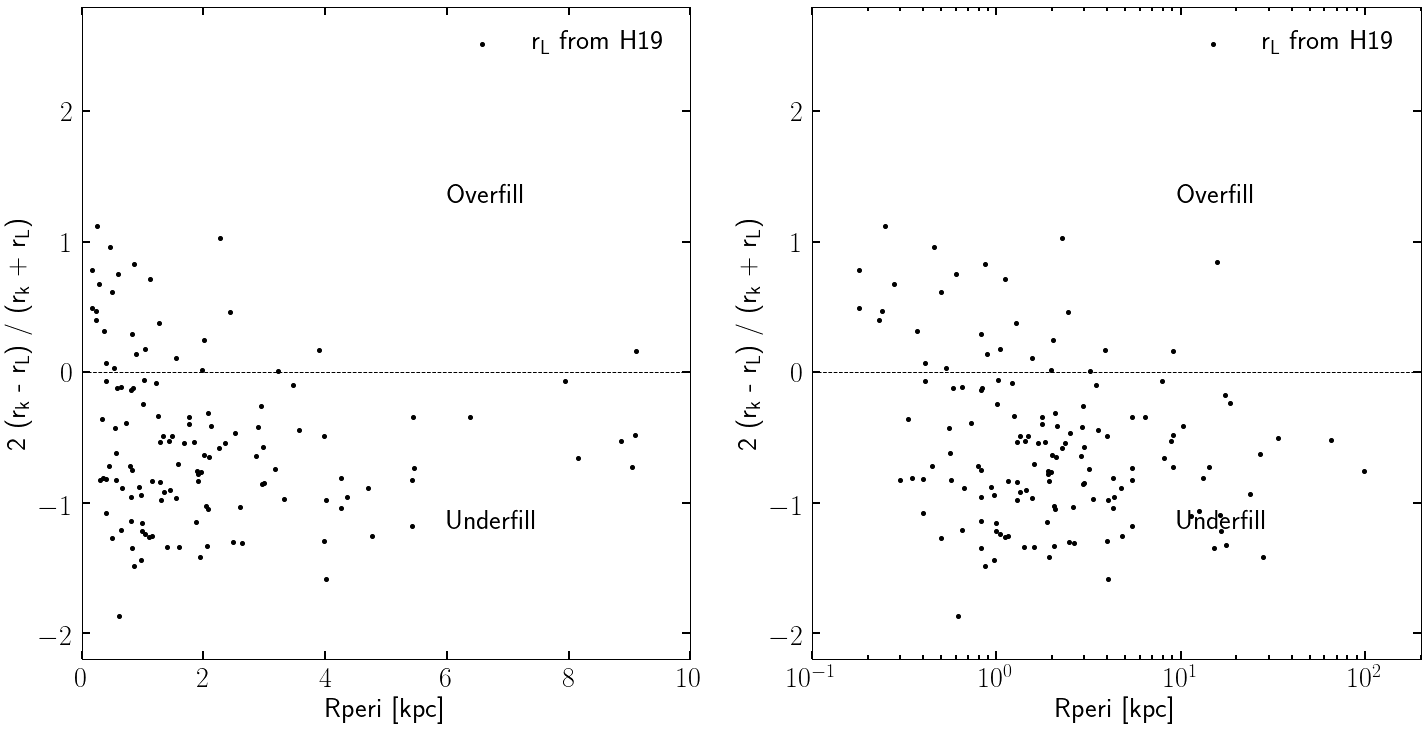

In [21]:
# Attempt to reproduce Webb+ 2013 ApJ 764 124 Fig. 12

fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(24, 12))

for ax in [ax1, ax2]:
    # tidal_radius_1e12, tidal_radius, rt_hilker, Rperi, Rapo, Mgc, Menclosed, king_tidal_radius_parsec
    r_k = data[:,7]  # fitted King (1962) radius from Harris (1996, 2010 ed.)
    r_l = data[:,2]  # limiting radius as calculated by Hilker (using eq. 8 of Webb+ 2013 ApJ 764 124)
    ratio = 2*(r_k - r_l)/(r_k + r_l)
    ax.plot(data[:,3], ratio, "ko", ms=4, label="r$_\\text{L}$ from H19")

    r_t = data[:,1]  # limiting radius as calculated
    ratio = 2*(r_k - r_t)/(r_k + r_t)
    # ax.plot(data[:,3], ratio, "ro", ms=4, label="calculated")

    ax.axhline(0, ls="--", lw=1, c="k")
    ax.text(0.6, 0.2, "Underfill", c="k", transform=ax.transAxes)
    ax.text(0.6, 0.7, "Overfill", c="k", transform=ax.transAxes)

    ax.set_ylim(-2.2, 2.8)
    ax.set_xlabel("Rperi [kpc]")
    ax.set_ylabel("2 (r$_\\text{k}$ - r$_\\text{L}$) / (r$_\\text{k}$ + r$_\\text{L}$)")
    ax.legend(frameon=False)
    
ax1.set_xlim(0, 10)
ax2.set_xlim(0.1, 200)
ax2.set_xscale("log")

pyplot.show()

# What does Rperi vs. Rapo look like? We might be interested in MW GCs /w non-circular orbits

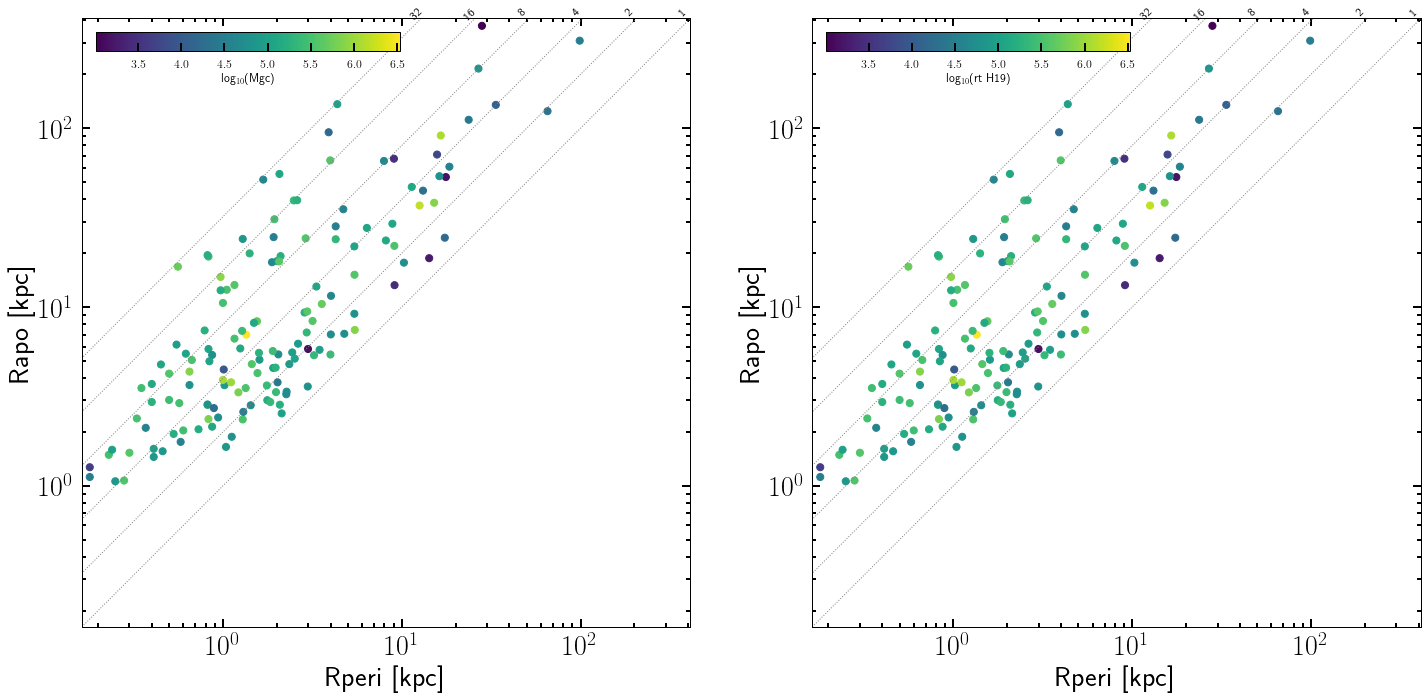

In [22]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(24, 12))

for ax, cax_xlabel in zip([ax1, ax2], ["Mgc", "rt H19"]):
    # tidal_radius_1e12, tidal_radius, rt_hilker, Rperi, Rapo, Mgc, Menclosed, king_tidal_radius_parsec
    ax.scatter(data[:,3], data[:,4], c=numpy.log10(data[:,5]), s=50)

    x = numpy.arange(1.1*numpy.max(data[:,4]))
    trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
    for i in [1, 2, 4, 8, 16, 32]:
        ax.plot(x, i*x, c="grey", lw=1, ls=":")
        imax, = numpy.where(i*x > numpy.max(data[:,4]))
        ax.text(x[imax[0]], 1.02, i, ha="center", va="top", fontsize=12, rotation="45", transform=trans)

    ax.set_xlabel("Rperi [kpc]")
    ax.set_ylabel("Rapo [kpc]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(0.9*numpy.min(data[:,3]), 1.1*numpy.max(data[:,4]))
    ax.set_ylim(0.9*numpy.min(data[:,3]), 1.1*numpy.max(data[:,4]))
    ax.set_aspect(1)

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    cbaxes = inset_axes(ax, width="50%", height="3%", loc="upper left") 
    cax = pyplot.colorbar(ax.get_children()[0], cax=cbaxes, orientation="horizontal")
    cax.ax.set_xlabel("log$_{{10}}$({0})".format(cax_xlabel), fontsize=12)
    cax.ax.tick_params(axis="both", which="major", labelsize=12)

pyplot.show()

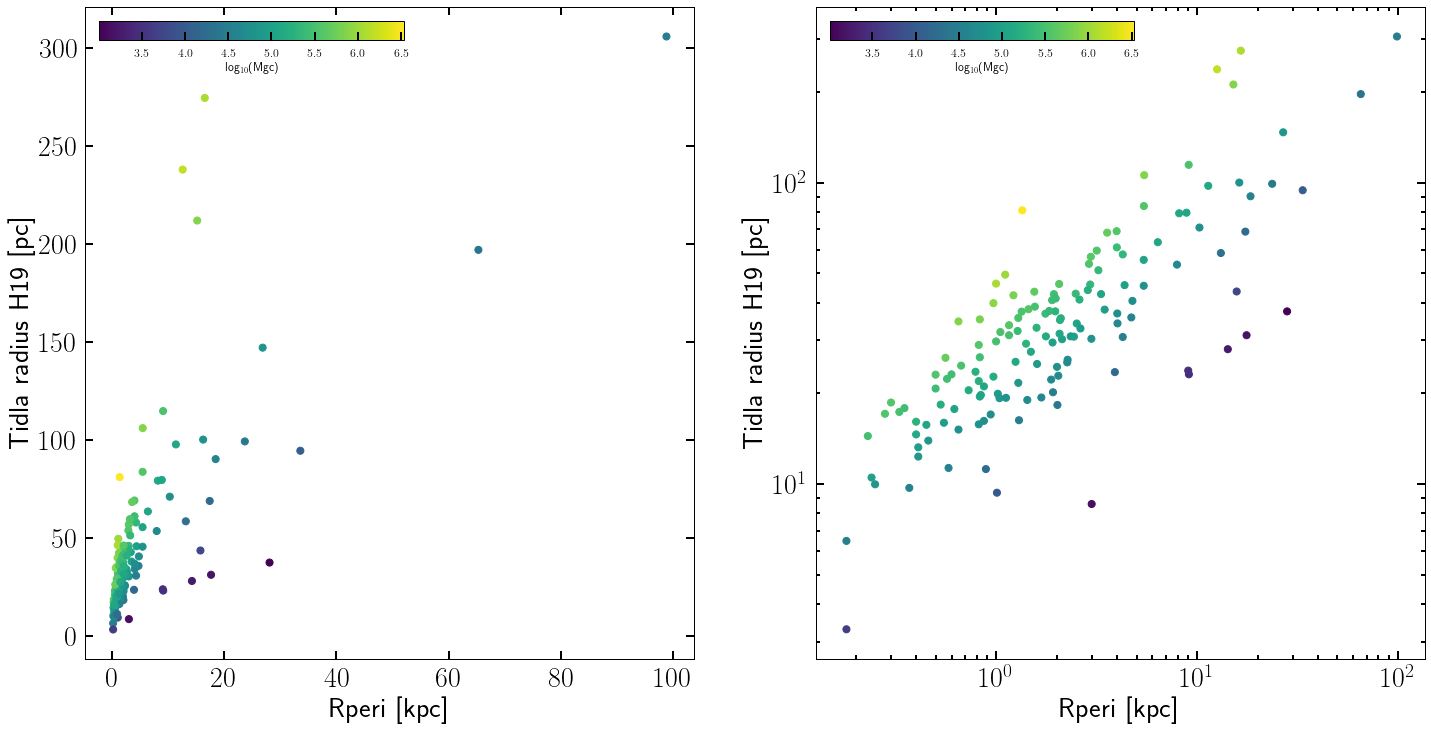

In [23]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(24, 12))

for ax in [ax1, ax2]:
    # tidal_radius_1e12, tidal_radius, rt_hilker, Rperi, Rapo, Mgc, Menclosed, king_tidal_radius_parsec
    ax.scatter(data[:,3], data[:,1], c=numpy.log10(data[:,5]), s=50)

    ax.set_xlabel("Rperi [kpc]")
    ax.set_ylabel("Tidla radius H19 [pc]")

    cax_xlabel = "Mgc"
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    cbaxes = inset_axes(ax, width="50%", height="3%", loc="upper left") 
    cax = pyplot.colorbar(ax.get_children()[0], cax=cbaxes, orientation="horizontal")
    cax.ax.set_xlabel("log$_{{10}}$({0})".format(cax_xlabel), fontsize=12)
    cax.ax.tick_params(axis="both", which="major", labelsize=12)

ax2.set_xscale("log")
ax2.set_yscale("log")    

pyplot.show()